### IMPORTS

##### REQUIRED INSTALLATIONS

In [ ]:
!pip3 install nlpaug scikit-multilearn nltk
!pip3 install transformers
!pip3 install --upgrade torch
!pip3 install --upgrade protobuf
!pip3 install hi-ml-multimodal

##### FOR DATA

In [ ]:
import os
import json
import imghdr
import tempfile
import scipy as sp
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
from pathlib import Path
from typing import Tuple
from scipy import ndimage
from typing import List, Any
from enum import Enum, unique
from nltk.corpus import wordnet
from collections import defaultdict
import nlpaug.augmenter.word as naw
from scipy.spatial.distance import cdist
from skmultilearn.model_selection import iterative_train_test_split

##### FOR PLOTTING AND UI

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from IPython.display import display
from IPython.display import Markdown
from sklearn.decomposition import PCA

import shap
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

##### FOR MACHINE LEARNING AND STUFF

In [ ]:
import torch
import transformers
import torch.nn as nn

import torch.nn.functional as F
from torchvision import transforms
from transformers import BertModel, AutoModel
from torchvision.transforms import ToPILImage
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as F
from torchvision.datasets.utils import download_url
from transformers import BertTokenizer, AutoTokenizer, AutoModel


from health_multimodal.common.visualization import plot_phrase_grounding_similarity_map
from health_multimodal.text import get_bert_inference
from health_multimodal.text.utils import BertEncoderType
from health_multimodal.image import get_image_inference
from health_multimodal.image.utils import ImageModelType
from health_multimodal.image.model import ImageEncoderType
from health_multimodal.vlp import ImageTextInferenceEngine
from health_multimodal.image import ImageInferenceEngine
from health_multimodal.image import ImageModel

from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.cuda.amp import GradScaler, autocast
\from torch.utils.tensorboard import SummaryWriter


### DATA LOADING (IUXray)

In [28]:
# Define the folder path
folder_path = 'images/images_normalized'
image_files = [
    os.path.join(folder_path, f) 
    for f in os.listdir(folder_path) 
    if os.path.isfile(os.path.join(folder_path, f)) and imghdr.what(os.path.join(folder_path, f))
]
reports = pd.read_csv('indiana_reports.csv')
projections = pd.read_csv('indiana_projections.csv')
projections_frontal = projections[projections.projection=='Frontal'].reset_index(drop=True)
unique_id_frontal=list(projections[projections.projection=='Frontal'].uid.unique())
reports_frontal = reports[reports['uid'].isin(unique_id_frontal)]
# Find rows where 'uid' is duplicated
duplicate_uids = projections_frontal[projections_frontal.duplicated(subset='uid', keep=False)]


##### CHECK SOME SAMPLE IMAGES

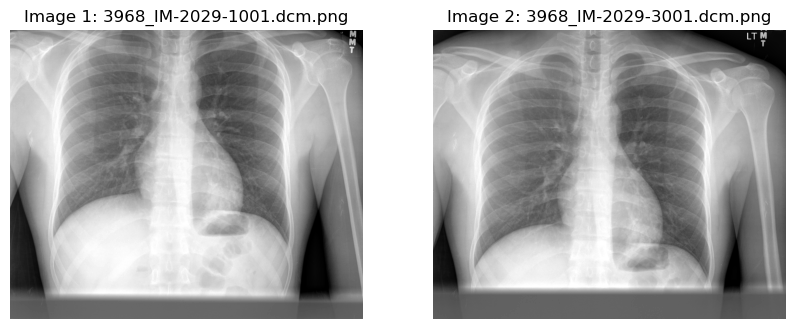

In [58]:
# Define the base directory for images
base_dir = 'images/images_normalized'

# Filter DataFrame for a specific UID, e.g., 62
selected_uid = 3968
uid_images = projections_frontal[projections_frontal['uid'] == selected_uid]['filename'].values

# Load the two images based on file paths
image1 = Image.open(os.path.join(base_dir, uid_images[0]))
image2 = Image.open(os.path.join(base_dir, uid_images[1]))

# Display the two images side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(image1, cmap='gray')
axs[0].set_title(f'Image 1: {uid_images[0]}')
axs[0].axis('off')

axs[1].imshow(image2, cmap='gray')
axs[1].set_title(f'Image 2: {uid_images[1]}')
axs[1].axis('off')

plt.show()


##### REMOVE DUPLICATES

In [38]:
# Keep only the first instance of each 'uid' and drop the rest
projections_frontal_nodup = projections_frontal.drop_duplicates(subset='uid', keep='first')
reports_frontal_img = pd.merge(reports_frontal, projections_frontal_nodup, on='uid', how='inner').reset_index(drop=True)
# Create a new column 'reports' by concatenating 'findings' and 'impression' with a space in between
reports_frontal_img['reports'] = reports_frontal_img['findings'].fillna('') + " " + reports_frontal_img['impression'].fillna('')

### LOAD CHEXBERT FOR REPORT ANNOTATION. CITE: "CheXbert: Combining Automatic Labelers and Expert Annotations for Accurate Radiology Report Labeling Using BERT"

In [44]:
checkpoint_path = 'chexbert.pth'
NUM_EPOCHS = 8        #Number of epochs to train for
BATCH_SIZE = 18       #Change this depending on GPU memory
NUM_WORKERS = 4       #A value of 0 means the main process loads the data
LEARNING_RATE = 2e-5
LOG_EVERY = 200       #iterations after which to log status during training
VALID_NITER = 2000    #iterations after which to evaluate model and possibly save (if dev performance is a new max)
PRETRAIN_PATH = None  #path to pretrained model, such as BlueBERT or BioBERT
PAD_IDX = 0           #padding index as required by the tokenizer 

#CONDITIONS is a list of all 14 medical observations 
CONDITIONS = ['Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
              'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
              'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
              'Support Devices', 'No Finding']
CLASS_MAPPING = {0: "Blank", 1: "Positive", 2: "Negative", 3: "Uncertain"}

def get_impressions_from_csv(path):	
        df = pd.read_csv(path)
        imp = df['Report Impression']
        imp = imp.str.strip()
        imp = imp.replace('\n',' ', regex=True)
        imp = imp.replace('\s+', ' ', regex=True)
        imp = imp.str.strip()
        return imp

def tokenize(impressions, tokenizer):
        new_impressions = []
        print("\nTokenizing report impressions. All reports are cut off at 512 tokens.")
        for i in tqdm(range(impressions.shape[0])):
                tokenized_imp = tokenizer.tokenize(impressions.iloc[i])
                if tokenized_imp: #not an empty report
                        res = tokenizer.encode_plus(tokenized_imp)['input_ids']
                        if len(res) > 512: #length exceeds maximum size
                                #print("report length bigger than 512")
                                res = res[:511] + [tokenizer.sep_token_id]
                        new_impressions.append(res)
                else: #an empty report
                        new_impressions.append([tokenizer.cls_token_id, tokenizer.sep_token_id]) 
        return new_impressions

def load_list(path):
        with open(path, 'r') as filehandle:
                impressions = json.load(filehandle)
                return impressions
            

class UnlabeledDataset(Dataset):
        """The dataset to contain report impressions without any labels."""
        
        def __init__(self):
                """ Initialize the dataset object
                @param csv_path (string): path to the csv file containing rhe reports. It
                                          should have a column named "Report Impression"
                """
                tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
                impressions = reports_frontal_img.reports #bert_tokenizer.get_impressions_from_csv(csv_path)
                self.encoded_imp = tokenize(impressions, tokenizer)

        def __len__(self):
                """Compute the length of the dataset

                @return (int): size of the dataframe
                """
                return len(self.encoded_imp)

        def __getitem__(self, idx):
                """ Functionality to index into the dataset
                @param idx (int): Integer index into the dataset

                @return (dictionary): Has keys 'imp', 'label' and 'len'. The value of 'imp' is
                                      a LongTensor of an encoded impression. The value of 'label'
                                      is a LongTensor containing the labels and 'the value of
                                      'len' is an integer representing the length of imp's value
                """
                if torch.is_tensor(idx):
                        idx = idx.tolist()
                imp = self.encoded_imp[idx]
                imp = torch.LongTensor(imp)
                return {"imp": imp, "len": imp.shape[0]}

def collate_fn_no_labels(sample_list):
    """Custom collate function to pad reports in each batch to the max len,
       where the reports have no associated labels
    @param sample_list (List): A list of samples. Each sample is a dictionary with
                               keys 'imp', 'len' as returned by the __getitem__
                               function of ImpressionsDataset

    @returns batch (dictionary): A dictionary with keys 'imp' and 'len' but now
                                 'imp' is a tensor with padding and batch size as the
                                 first dimension. 'len' is a list of the length of 
                                 each sequence in batch
    """
    tensor_list = [s['imp'] for s in sample_list]
    batched_imp = torch.nn.utils.rnn.pad_sequence(tensor_list,
                                                  batch_first=True,
                                                  padding_value=PAD_IDX)
    len_list = [s['len'] for s in sample_list]
    batch = {'imp': batched_imp, 'len': len_list}
    return batch

def load_unlabeled_data(batch_size=BATCH_SIZE, num_workers=NUM_WORKERS,
                        shuffle=False):
    """ Create UnlabeledDataset object for the input reports
    @param csv_path (string): path to csv file containing reports
    @param batch_size (int): the batch size. As per the BERT repository, the max batch size
                             that can fit on a TITAN XP is 6 if the max sequence length
                             is 512, which is our case. We have 3 TITAN XP's
    @param num_workers (int): how many worker processes to use to load data
    @param shuffle (bool): whether to shuffle the data or not  
    
    @returns loader (dataloader): dataloader object for the reports
    """
    collate_fn = collate_fn_no_labels
    dset = UnlabeledDataset()
    loader = torch.utils.data.DataLoader(dset, batch_size=batch_size, shuffle=shuffle,
                                         num_workers=num_workers, collate_fn=collate_fn)
    return loader


class bert_labeler(nn.Module):
    def __init__(self, p=0.1, clinical=False, freeze_embeddings=False, pretrain_path=None):
        """ Init the labeler module
        @param p (float): p to use for dropout in the linear heads, 0.1 by default is consistant with 
                          transformers.BertForSequenceClassification
        @param clinical (boolean): True if Bio_Clinical BERT desired, False otherwise. Ignored if
                                   pretrain_path is not None
        @param freeze_embeddings (boolean): true to freeze bert embeddings during training
        @param pretrain_path (string): path to load checkpoint from
        """
        super(bert_labeler, self).__init__()

        if pretrain_path is not None:
            self.bert = BertModel.from_pretrained(pretrain_path)
        elif clinical:
            self.bert = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
        else:
            self.bert = BertModel.from_pretrained('bert-base-uncased')
            
        if freeze_embeddings:
            for param in self.bert.embeddings.parameters():
                param.requires_grad = False
                
        self.dropout = nn.Dropout(p)
        #size of the output of transformer's last layer
        hidden_size = self.bert.pooler.dense.in_features
        #classes: present, absent, unknown, blank for 12 conditions + support devices
        self.linear_heads = nn.ModuleList([nn.Linear(hidden_size, 4, bias=True) for _ in range(13)])
        #classes: yes, no for the 'no finding' observation
        self.linear_heads.append(nn.Linear(hidden_size, 2, bias=True))

    def forward(self, source_padded, attention_mask):
        """ Forward pass of the labeler
        @param source_padded (torch.LongTensor): Tensor of word indices with padding, shape (batch_size, max_len)
        @param attention_mask (torch.Tensor): Mask to avoid attention on padding tokens, shape (batch_size, max_len)
        @returns out (List[torch.Tensor])): A list of size 14 containing tensors. The first 13 have shape 
                                            (batch_size, 4) and the last has shape (batch_size, 2)  
        """
        #shape (batch_size, max_len, hidden_size)
        final_hidden = self.bert(source_padded, attention_mask=attention_mask)[0]
        #shape (batch_size, hidden_size)
        cls_hidden = final_hidden[:, 0, :].squeeze(dim=1)
        cls_hidden = self.dropout(cls_hidden)
        out = []
        for i in range(14):
            out.append(self.linear_heads[i](cls_hidden))
        return out
            

def generate_attention_masks(batch, source_lengths, device):
    """Generate masks for padded batches to avoid self-attention over pad tokens
    @param batch (Tensor): tensor of token indices of shape (batch_size, max_len)
                           where max_len is length of longest sequence in the batch
    @param source_lengths (List[Int]): List of actual lengths for each of the
                           sequences in the batch
    @param device (torch.device): device on which data should be

    @returns masks (Tensor): Tensor of masks of shape (batch_size, max_len)
    """
    masks = torch.ones(batch.size(0), batch.size(1), dtype=torch.float)
    for idx, src_len in enumerate(source_lengths):
        masks[idx, src_len:] = 0
    return masks.to(device)

def label(checkpoint_path):
    """Labels a dataset of reports
    @param checkpoint_path (string): location of saved model checkpoint 
    @param csv_path (string): location of csv with reports

    @returns y_pred (List[List[int]]): Labels for each of the 14 conditions, per report  
    """
    ld = load_unlabeled_data()
    
    model = bert_labeler()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    if torch.cuda.device_count() > 0: #works even if only 1 GPU available
        print("Using", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(model) #to utilize multiple GPU's
        model = model.to(device)
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
        new_state_dict = OrderedDict()
        for k, v in checkpoint['model_state_dict'].items():
            name = k[7:] # remove `module.`
            new_state_dict[name] = v
        model.load_state_dict(new_state_dict)
        
    was_training = model.training
    model.eval()
    y_pred = [[] for _ in range(len(CONDITIONS))]

    print("\nBegin report impression labeling. The progress bar counts the # of batches completed:")
    print("The batch size is %d" % BATCH_SIZE)
    with torch.no_grad():
        for i, data in enumerate(tqdm(ld)):
            batch = data['imp'] #(batch_size, max_len)
            batch = batch.to(device)
            src_len = data['len']
            batch_size = batch.shape[0]
            attn_mask = generate_attention_masks(batch, src_len, device)

            out = model(batch, attn_mask)

            for j in range(len(out)):
                curr_y_pred = out[j].argmax(dim=1) #shape is (batch_size)
                y_pred[j].append(curr_y_pred)

        for j in range(len(y_pred)):
            y_pred[j] = torch.cat(y_pred[j], dim=0)
             
    if was_training:
        model.train()

    y_pred = [t.tolist() for t in y_pred]
    return y_pred

y_pred = label(checkpoint_path)
pred_df = pd.DataFrame(np.array(y_pred).T, columns=CONDITIONS)
pred_df['reports'] = reports_frontal_img.reports
new_cols = ['reports'] + CONDITIONS
pred_df= pred_df[new_cols]

# Perform a left join to keep all rows in reports_frontal_img
reports_frontal_img_labeled = pd.merge(reports_frontal_img, pred_df, on='reports', how='right').reset_index(drop=True)
# Concatenate reports_frontal_img and pred_df along the columns (axis=1)
combined_df = pd.concat([reports_frontal_img.reset_index(drop=True), pred_df.reset_index(drop=True)], axis=1)

# Drop the duplicate 'reports' column if needed
# Assuming the first instance of 'reports' column is sufficient
combined_df = combined_df.loc[:, ~combined_df.columns.duplicated()]
combined_df.to_csv('data.csv',index=False)
reports_frontal_img_labeled.to_csv('IUXray_filtered_labeled_frontalview.csv')

### BioVil-T: PRETRAINED MODEL LOADING AND ZERO SHOT CLASSIFICATION ON IUXRAY

In [36]:
iuxray_df=pd.read_csv('iuxray_frontal_14labels.csv')

##### DOWNLAOD PRETRAINED BIOVIL-T IMAGE AND TEXT MODELS

In [70]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BIOMED_VLP_CXR_BERT_SPECIALIZED = "microsoft/BiomedVLP-CXR-BERT-specialized"
BIOMED_VLP_BIOVIL_T = "microsoft/BiomedVLP-BioViL-T"
HF_URL = "https://huggingface.co"

CXR_BERT_COMMIT_TAG = "v1.1"
BIOVIL_T_COMMIT_TAG = "v1.0"

BIOVIL_T_IMAGE_WEIGHTS_NAME = "biovil_t_image_model_proj_size_128.pt"
BIOVIL_T_IMAGE_WEIGHTS_URL = (
    f"{HF_URL}/{BIOMED_VLP_BIOVIL_T}/resolve/{BIOVIL_T_COMMIT_TAG}/{BIOVIL_T_IMAGE_WEIGHTS_NAME}"  # noqa: E501
)
BIOVIL_T_IMAGE_WEIGHTS_MD5 = "a83080e2f23aa584a4f2b24c39b1bb64"

# transform = transforms.Compose([
#         transforms.Resize((512, 512)),  # Resize to the expected input size of the model
#         transforms.ToTensor(),         # Convert the image to a PyTorch Tensor
#         transforms.Normalize(
#             mean=[0.485, 0.456, 0.406],   # Normalize to the same mean as ImageNet-trained models
#             std=[0.229, 0.224, 0.225]     # Normalize to the same std as ImageNet-trained models
#         )
#     ])



transform = transforms.Compose([
        transforms.Resize((512, 512)), # Resize to the expected input size of the model
        transforms.CenterCrop(448),
        transforms.ToTensor(),         # Convert the image to a PyTorch Tensor
        
    ])


def load_text_model():
    text_model_name = "microsoft/BiomedVLP-BioViL-T"
    tokenizer = AutoTokenizer.from_pretrained(text_model_name, trust_remote_code=True)
    text_model = AutoModel.from_pretrained(text_model_name, trust_remote_code=True)
    text_model.eval()
    return tokenizer,text_model.to(device)

def get_text_emb(tokenizer,text_model,text_prompts):
    with torch.no_grad():
        tokenizer_output = tokenizer.batch_encode_plus(
            batch_text_or_text_pairs=text_prompts,
            add_special_tokens=True,
            padding='longest',
            return_tensors='pt'
        ).to(device)
        embeddings = text_model.get_projected_text_embeddings(
            input_ids=tokenizer_output.input_ids,
            attention_mask=tokenizer_output.attention_mask
        )
    return embeddings


@unique
class ImageEncoderType(str, Enum):
    RESNET18 = "resnet18"
    RESNET50 = "resnet50"
    RESNET18_MULTI_IMAGE = "resnet18_multi_image"
    RESNET50_MULTI_IMAGE = "resnet50_multi_image"

    @classmethod
    def get_members(cls, multi_image_encoders_only: bool) -> List[ImageEncoderType]:
        if multi_image_encoders_only:
            return [cls.RESNET18_MULTI_IMAGE, cls.RESNET50_MULTI_IMAGE]
        else:
            return [member for member in cls]


@unique
class ImageEncoderWeightTypes(str, Enum):
    RANDOM = "random"
    IMAGENET = "imagenet"
    BIOVIL = "biovil"
    BIOVIL_T = "biovil_t"
    
def _download_biovil_t_image_model_weights() -> Path:
    """Download image model weights from Hugging Face.

    More information available at https://huggingface.co/microsoft/microsoft/BiomedVLP-BioViL-T.
    """
    root_dir = tempfile.gettempdir()
    download_url(
        BIOVIL_T_IMAGE_WEIGHTS_URL, root=root_dir, filename=BIOVIL_T_IMAGE_WEIGHTS_NAME, md5=BIOVIL_T_IMAGE_WEIGHTS_MD5
    )
    return Path(root_dir, BIOVIL_T_IMAGE_WEIGHTS_NAME)
def get_biovil_t_image_encoder(**kwargs: Any) -> ImageModel:
    """Download weights from Hugging Face and instantiate the image model."""
    JOINT_FEATURE_SIZE = 128
    biovilt_checkpoint_path = _download_biovil_t_image_model_weights()
    model_type = ImageEncoderType.RESNET50_MULTI_IMAGE
    image_model = ImageModel(
        img_encoder_type=model_type,
        joint_feature_size=JOINT_FEATURE_SIZE,
        pretrained_model_path=biovilt_checkpoint_path,
        **kwargs,
    )
    return image_model.to(device)

def get_local_img_emb(image_path):
    # Load and transform the image
    image = Image.open(image_path).convert("RGB")  # Ensure the image is in RGB mode
    transformed_image = transform(image)

    # Move the image tensor to the same device as the model
    transformed_image_batched = transformed_image.unsqueeze(0).to(device)

    # Set the model to evaluation mode
    image_model.eval()

    # Perform inference and return the embeddings
    with torch.no_grad():
        projected_img_emb = image_model.get_patchwise_projected_embeddings(
            transformed_image_batched, normalize=True
        )
    return projected_img_emb[0]

def get_global_img_emb(image_path):
    
    image = Image.open(image_path).convert("RGB")  # Ensure the image is in RGB mode

    # Transform the image
    transformed_image = transform(image)
    transformed_image_batched=transformed_image.unsqueeze(0).to(device)
    projected_img_emb=image_model.forward(transformed_image_batched).projected_global_embedding
    projected_img_emb = F.normalize(projected_img_emb, dim=-1)
    return projected_img_emb[0]


def get_projected_global_embedding(image_path) -> torch.Tensor:
        """Compute global image embedding in the joint latent space.

        :param image_path: Path to the image to compute embeddings for.
        :return: Torch tensor containing l2-normalised global image embedding [joint_feature_dim,]
                 where joint_feature_dim is the dimensionality of the joint latent space.
        """
        input_image, _ = self.load_and_transform_input_image(image_path, self.transform)
        projected_img_emb = self.model.forward(input_image).projected_global_embedding
        projected_img_emb = F.normalize(projected_img_emb, dim=-1)

        assert projected_img_emb.shape[0] == 1
        assert projected_img_emb.ndim == 2

        return projected_img_emb[0]
    

image_model = get_biovil_t_image_encoder()
tokenizer,text_model = load_text_model()

Using downloaded and verified file: /tmp/biovil_t_image_model_proj_size_128.pt


Some weights of the model checkpoint at microsoft/BiomedVLP-BioViL-T were not used when initializing CXRBertModel: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing CXRBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CXRBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


##### SPLIT DATASET INTO TRAIN-VAL-TEST

In [ ]:
# Define disease columns based on the user's description
disease_columns = [
    'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
    'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
    'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
    'Support Devices', 'No Finding'
]
rare_classes=['Enlarged Cardiomediastinum',
             'Edema',
             'Consolidation',
             'Pneumonia',
             'Pneumothorax',
             'Pleural Other']
iuxray_df = pd.read_csv('iuxray_frontal_14labels.csv')
# Convert the DataFrame to a NumPy array
X = iuxray_df.index.values.reshape(-1, 1)  # Indices as feature placeholders
y = iuxray_df[disease_columns].values      # Multi-label targets

# First, split into train+val and test
X_train_val, y_train_val, X_test, y_test = iterative_train_test_split(
    X, y, test_size=0.1
)

# Then, split train+val into train and val
X_train, y_train, X_val, y_val = iterative_train_test_split(
    X_train_val, y_train_val, test_size=0.1
)

# Map indices back to DataFrames
train_df = iuxray_df.iloc[X_train.flatten()]
val_df = iuxray_df.iloc[X_val.flatten()]
test_df = iuxray_df.iloc[X_test.flatten()]

print(f"Training Samples: {len(train_df)}")
print(f"Validation Samples: {len(val_df)}")
print(f"Testing Samples: {len(test_df)}")

##### OPTIONAL: DATA AUGMENTATION

In [ ]:
# Define image transformations
image_transforms = {
    "normal": transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(448),
        transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    "rare": transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(30),
#         transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
        transforms.CenterCrop(448),
        transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

# Define text augmenter (optional)

text_augmenter = naw.RandomWordAug(action="swap", aug_min=1, aug_max=3)


# Instantiate a ToPILImage transform
to_pil_image = ToPILImage()

augmented_images = []
image_dir = "images/images_normalized"

for idx, row in train_df.iterrows():
    image_path = os.path.join(image_dir, row['filename'])
    image = Image.open(image_path).convert("RGB")

    # Check if the sample belongs to a rare class
    is_rare = any(row[rare_classes] == 1)

    # Apply aggressive augmentation for rare classes
    if is_rare:
        for i in range(3):  # Create 3 augmented copies
            augmented_image_tensor = image_transforms["rare"](image)

            # Convert Tensor to PIL Image
            augmented_image = to_pil_image(augmented_image_tensor)

            # Save the augmented image
            new_filename = f"aug_{i}_{row['filename']}"
            save_path = os.path.join(image_dir, new_filename)
            augmented_image.save(save_path)

            augmented_images.append({
                "filename": new_filename,
                "reports": row["reports"],
                **row[disease_columns].to_dict()  # Keep the same labels
            })

augmented_reports = []

for data in augmented_images:
    augmented_report = text_augmenter.augment(data["reports"])
    augmented_reports.append({
        "filename": data["filename"],
        "reports": augmented_report,
        **data
    })

augmented_df = pd.DataFrame(augmented_reports)
train_df_augmented = pd.concat([train_df, augmented_df], ignore_index=True)


##### CLEANING 'MAGIC' REPORTS IN THE DATASET :/

In [ ]:
def filter_invalid_rows(dataframe, image_dir):
    valid_rows = []
    for idx, row in dataframe.iterrows():
        try:
            image_path = os.path.join(image_dir, row['filename'])
            # Check if image is readable
            with Image.open(image_path) as img:
                img.verify()
            # Ensure the report is non-empty
            if pd.isna(row["reports"]) or row["reports"].strip() == "":
                raise ValueError("Empty report")
            valid_rows.append(row)
        except Exception as e:
            print(f"Invalid row at index {idx}: {e}")
    return pd.DataFrame(valid_rows)
print('CLEANING TRAIN')
train_df_augmented=pd.read_csv('iuxray_augmented_train.csv')
train_df_cleaned = filter_invalid_rows(train_df_augmented, image_dir).reset_index(drop=True)
print('CLEARNING VAL')
val_df=pd.read_csv('iuxray_val.csv')
val_df_cleaned = filter_invalid_rows(val_df, image_dir).reset_index(drop=True)


##### ZERO-SHOT TOP-3 ACCURACY ON VAL SET

In [58]:
def zero_shot_classification_top_k(
    image_path, text_prompts, image_model, text_model, tokenizer, k=3
):
    """
    Perform zero-shot classification and extract top-k predictions.
    
    :param image_path: Path to the image file.
    :param text_prompts: List of text descriptions (e.g., disease labels or descriptions).
    :param image_model: Pretrained image model.
    :param text_model: Pretrained text model.
    :param tokenizer: Tokenizer for the text model.
    :param k: Number of top predictions to extract (default is 3).
    :return: A sorted list of top-k predictions (label-score pairs) and a dictionary of all normalized scores.
    """
    # Generate image embedding
    image_model.eval()
    image_emb = get_global_img_emb(image_path)

    # Generate text embeddings
    text_embs = get_text_emb(tokenizer, text_model, text_prompts)

    # Calculate similarity scores (cosine similarity)
    similarity_scores = F.cosine_similarity(image_emb.unsqueeze(0), text_embs, dim=1)

    # Normalize similarity scores using softmax
    normalized_scores = F.softmax(similarity_scores, dim=0)

    # Zip scores with text prompts
    prompt_scores = list(zip(text_prompts, normalized_scores.tolist()))

    # Sort by scores in descending order
    sorted_scores = sorted(prompt_scores, key=lambda x: x[1], reverse=True)

    # Get the top-k predictions
    top_k_predictions = sorted_scores[:k]

    return top_k_predictions, dict(prompt_scores)

def populate_predicted_top_k(df, image_dir, text_prompts, image_model, text_model, tokenizer, k=3):
    """
    Populate predicted top-k labels for each row in the dataset.

    :param df: DataFrame containing the dataset.
    :param image_dir: Directory containing image files.
    :param text_prompts: List of text descriptions (e.g., disease labels).
    :param image_model: Pretrained image model.
    :param text_model: Pretrained text model.
    :param tokenizer: Tokenizer for the text model.
    :param k: Number of top predictions to extract (default is 3).
    :return: List of top-k predictions for each row.
    """
    predicted_top_k = []
    
    for i in tqdm.tqdm(range(len(df))):
        # Get the image path
        image_path = os.path.join(image_dir, df.loc[i, 'filename'])
        
        # Perform zero-shot classification for the current image
        try:
            top_k_predictions, _ = zero_shot_classification_top_k(
                image_path, text_prompts, image_model, text_model, tokenizer, k
            )
            # Store the top-k labels
            top_k_labels = [label for label, _ in top_k_predictions]
        except Exception as e:
            print(f"Error processing row {i}: {e}")
            top_k_labels = []
        
        predicted_top_k.append(top_k_labels)
    
    return predicted_top_k



def compute_top_k_accuracy_from_columns(df, disease_columns, k=3):
    """
    Compute top-1, top-2, and top-3 accuracy for each disease label based on 'target' and 'predicted_top_k' columns.

    :param df: DataFrame containing 'target' and 'predicted_top_k' columns.
    :param disease_columns: List of all disease labels.
    :param k: Maximum value of k for top-k accuracy.
    :return: Dictionary with top-k accuracy for each disease label.
    """
    top_k_accuracies = defaultdict(lambda: {"top-1": 0, "top-2": 0, "top-3": 0, "total": 0})

    for _, row in df.iterrows():
        true_labels = set(row['target'].split(", "))  # Split true labels into a set
        predicted_labels = row['predicted_top_k']  # Get predicted labels (already a list)

        # Update total count for each true label
        for label in true_labels:
            top_k_accuracies[label]["total"] += 1

        # Check top-1, top-2, and top-3 predictions for matches
        for i, top_k in enumerate(["top-1", "top-2", "top-3"], start=1):
            if any(label in predicted_labels[:i] for label in true_labels):
                for label in true_labels:
                    top_k_accuracies[label][top_k] += 1

    # Calculate accuracy percentages
    for label, counts in top_k_accuracies.items():
        for top_k in ["top-1", "top-2", "top-3"]:
            if counts["total"] > 0:
                counts[top_k] = counts[top_k] / counts["total"]

    return dict(top_k_accuracies)


# Compute top-1, top-2, top-3 accuracy for each disease label
disease_columns = [
    'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
    'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
    'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
    'Support Devices', 'No Finding'
]

image_dir = "images/images_normalized"  # Path to the directory containing images
k = 3  # Top-3 predictions

# Create a new column 'target' with the diseases having value 1 for each row
val_df_cleaned['target'] = val_df_cleaned[disease_columns].apply(lambda row: ', '.join(row.index[row == 1]), axis=1)
# Populate predicted_top_k
val_df_cleaned['predicted_top_k'] = populate_predicted_top_k(
    val_df_cleaned, image_dir, disease_columns, image_model, text_model, tokenizer, k
)
top_k_accuracy_results = compute_top_k_accuracy_from_columns(val_df_cleaned, disease_columns, k=3)
top_k_accuracy_results

##### CHECK EMBEDDING QUALITY

In [31]:
def checkEmbQual(df):
# Initialize dictionaries to store embeddings
    image_embeddings = {disease: [] for disease in disease_columns}
    text_embeddings = {disease: [] for disease in disease_columns}
    for disease in disease_columns:
        disease_data = df[df[disease] == 1]  # Filter first 10 positive samples
        print('Processing: ', disease)
        for _, row in tqdm.tqdm(disease_data.iterrows()):
            try:
                # Extract and store image embedding
                image_path = image_dir+"/" + row["filename"]  # Replace with your actual image path column
                img_emb = get_global_img_emb(image_path)

                # Detach image embedding and move it to CPU to release GPU memory
                img_emb = img_emb.detach().cpu()
                image_embeddings[disease].append(img_emb)

                # Extract and store text embedding
                text_prompt = [row["reports"]]  # Replace with your actual text column
                text_emb = get_text_emb(tokenizer, text_model, text_prompt)

                # Detach text embedding and move it to CPU to release GPU memory
                text_emb = text_emb.squeeze(0).detach().cpu()
                text_embeddings[disease].append(text_emb)

                # Free up GPU memory
                torch.cuda.empty_cache()

            except Exception as e:
                print(f"Error processing {row['filename']}: {e}")
    return image_embeddings,text_embeddings
image_embeddings,text_embeddings=checkEmbQual(train_df_cleaned)

Processing:  Enlarged Cardiomediastinum


70it [00:06, 10.18it/s]


Processing:  Cardiomegaly


415it [00:40, 10.16it/s]


Processing:  Lung Opacity


516it [00:50, 10.24it/s]


Processing:  Lung Lesion


165it [00:16, 10.30it/s]


Processing:  Edema


49it [00:04, 10.20it/s]


Processing:  Consolidation


31it [00:03, 10.25it/s]


Processing:  Pneumonia


68it [00:06, 10.30it/s]


Processing:  Atelectasis


216it [00:21, 10.07it/s]


Processing:  Pneumothorax


20it [00:01, 10.01it/s]


Processing:  Pleural Effusion


129it [00:12, 10.20it/s]


Processing:  Pleural Other


56it [00:05, 10.20it/s]


Processing:  Fracture


127it [00:12, 10.38it/s]


Processing:  Support Devices


163it [00:15, 10.26it/s]


Processing:  No Finding


1431it [02:19, 10.28it/s]


##### PLOTTING THE EMBEDDINGS

In [ ]:
def reduce_dimensionality(embeddings, method="pca", n_components=50):
    """
    Reduces dimensionality of embeddings using PCA or UMAP.

    Args:
        embeddings (list of numpy arrays): High-dimensional embeddings.
        method (str): Dimensionality reduction method ('pca' or 'umap').
        n_components (int): Number of components to reduce to.
    
    Returns:
        Reduced embeddings as a numpy array.
    """
    embeddings_np = np.array(embeddings)
    
    if method == "pca":
        pca = PCA(n_components=n_components, random_state=42)
        reduced_embeddings = pca.fit_transform(embeddings_np)
    elif method == "umap":
        from umap import UMAP
        umap = UMAP(n_components=n_components, random_state=42)
        reduced_embeddings = umap.fit_transform(embeddings_np)
    else:
        raise ValueError("Unsupported dimensionality reduction method. Use 'pca' or 'umap'.")
    
    return reduced_embeddings
def prepare_data_for_visualization(embeddings_dict):
    """
    Prepares embeddings and labels for visualization.

    Args:
        embeddings_dict (dict): A dictionary where keys are disease labels, and values are lists of embeddings.

    Returns:
        embeddings (list): Flattened embeddings.
        labels (list): Corresponding labels.
    """
    embeddings = []
    labels = []
    for idx, (disease, emb_list) in enumerate(embeddings_dict.items()):
        # Detach tensors, move to CPU, and flatten them
        embeddings.extend([emb.detach().cpu().numpy().flatten() if isinstance(emb, torch.Tensor) else emb.flatten() for emb in emb_list])
        labels.extend([idx] * len(emb_list))
    return embeddings, labels



def visualize_with_tsne(embeddings, labels, title, label_names):
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    embeddings_2d = tsne.fit_transform(np.array(embeddings))

    plt.figure(figsize=(16, 8))
    for label in np.unique(labels):
        idx = np.where(np.array(labels) == label)
        plt.scatter(embeddings_2d[idx, 0], embeddings_2d[idx, 1], label=label_names[label], alpha=0.7)
    
    plt.title(title)
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

# Correctly pass the dictionary for embeddings
image_embeddings_data, image_labels = prepare_data_for_visualization(image_embeddings)  # image_embeddings should be a dictionary
text_embeddings_data, text_labels = prepare_data_for_visualization(text_embeddings)    # text_embeddings should also be a dictionary

# Reduce dimensionality (e.g., PCA to 50 components)
reduced_image_embeddings = reduce_dimensionality(image_embeddings_data, method="pca", n_components=16)
reduced_text_embeddings = reduce_dimensionality(text_embeddings_data, method="pca", n_components=16)


visualize_with_tsne(reduced_image_embeddings, image_labels, "t-SNE for Image Embeddings", disease_columns)

# Visualize text embeddings
visualize_with_tsne(text_embeddings_data, text_labels, "t-SNE for Text Embeddings", disease_columns)


##### PAIRWISE INTRA AND INTER CLASS EMBEDDING DISTANCE

In [ ]:
from scipy.spatial.distance import cdist

def evaluate_pairwise_distances(embeddings, labels):
    """
    Computes intra-class and inter-class distances.

    Args:
        embeddings (list or np.array): Embeddings to be analyzed.
        labels (list): Ground truth labels for embeddings.

    Returns:
        None: Prints average intra-class and inter-class distances.
    """
    embeddings = np.array(embeddings)
    unique_labels = np.unique(labels)

    intra_distances = []
    inter_distances = []

    for label in unique_labels:
        # Get embeddings of the current class
        class_embeddings = embeddings[np.array(labels) == label]

        # Intra-class distances
        if len(class_embeddings) > 1:
            intra_dist = cdist(class_embeddings, class_embeddings).mean()
            intra_distances.append(intra_dist)

        # Inter-class distances
        other_embeddings = embeddings[np.array(labels) != label]
        inter_dist = cdist(class_embeddings, other_embeddings).mean()
        inter_distances.append(inter_dist)

    # Compute averages
    avg_intra = np.mean(intra_distances)
    avg_inter = np.mean(inter_distances)

    print(f"Average Intra-Class Distance: {avg_intra:.2f}")
    print(f"Average Inter-Class Distance: {avg_inter:.2f}")
    print(f"Separation Gap (Inter - Intra): {avg_inter - avg_intra:.2f}")
print(evaluate_pairwise_distances(image_embeddings_data, image_labels))
print(evaluate_pairwise_distances(text_embeddings_data, text_labels))


### VISUALIZATION WITH GRADCAM AND SHAP

##### CHOOSE A SAMPLE FOR EACH DISEASE

In [ ]:
temp_df=val_df[val_df['Lung Lesion']==1]
for i in temp_df.index:
    if 'Lung Lesion' in temp_df.loc[i].predicted_top_k:
        print(i,temp_df.loc[i].predicted_top_k)

##### ZERO-SHOT VISUALIZATION WITH GRADCAM

In [ ]:
# Ensure the model is on the CPU
image_model = image_model.to("cpu")
image_model.eval()

# Define the target layer for Grad-CAM
target_layer = image_model.encoder.encoder.layer4[-1]  # Last block of layer4

# Grad-CAM with a custom target function
class EmbeddingNormTarget:
    def __call__(self, model_output):
        """
        Compute the norm of the tensor as the scalar target.
        
        :param model_output: Output from the model's forward pass.
        :return: Scalar norm of the tensor.
        """
        return model_output.norm()

# Modify the Grad-CAM wrapper to handle tensors
class GradCAMCustom(GradCAM):
    def forward(self, input_tensor, targets, eigen_smooth):
        outputs = self.model(input_tensor)  # Outputs are tensors (feature maps)

        # Compute loss based on the norm of the tensor
        loss = sum([target(outputs) for target in targets])
        loss.backward(retain_graph=True)

        # Compute the Grad-CAM heatmap
        return super(GradCAM, self).forward(input_tensor, targets, eigen_smooth)

# Instantiate the Grad-CAM object (use CPU only)
cam = GradCAMCustom(model=image_model.encoder.encoder, target_layers=[target_layer])

# Define the transform (should match your preprocessing pipeline)
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.CenterCrop(448),
    transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Function to preprocess the image for Grad-CAM
def preprocess_image_for_gradcam(image_path):
    """
    Preprocess the image for Grad-CAM.
    
    :param image_path: Path to the input image.
    :return: Tuple of original image and preprocessed tensor.
    """
    image = Image.open(image_path).convert("RGB")
    original_image = np.asarray(image.resize((448, 448))).astype(np.float32) / 255.0  # Resize for visualization
    input_tensor = transform(image).unsqueeze(0).to("cpu")  # Ensure tensor is on CPU
    return original_image, input_tensor

# Function to generate Grad-CAM heatmap
def generate_gradcam(image_path):
    """
    Generate a Grad-CAM heatmap for a given image.
    
    :param image_path: Path to the input image.
    :return: Image with the Grad-CAM heatmap overlaid.
    """
    # Preprocess the image
    original_image, input_tensor = preprocess_image_for_gradcam(image_path)

    # Generate Grad-CAM using the tensor norm as the scalar target
    grayscale_cam = cam(input_tensor=input_tensor, targets=[EmbeddingNormTarget()])[0]

    # Combine Grad-CAM heatmap with the original image
    cam_image = show_cam_on_image(original_image, grayscale_cam, use_rgb=True)

    return cam_image

# Function to plot Grad-CAM
def plot_gradcam(image_path):
    """
    Plot the Grad-CAM heatmap for a given image.
    
    :param image_path: Path to the input image.
    """
    # Preprocess the image and generate Grad-CAM
    original_image, input_tensor = preprocess_image_for_gradcam(image_path)
    cam_image = generate_gradcam(image_path)

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the original image
    axes[0].imshow(original_image)
    axes[0].axis("off")
    axes[0].set_title("Original Scan)")

    # Plot the Grad-CAM image
    axes[1].imshow(cam_image)
    axes[1].axis("off")
    axes[1].set_title("Grad-CAM")

    # Show the figure
    plt.tight_layout()
    plt.show()

Lung Lesion


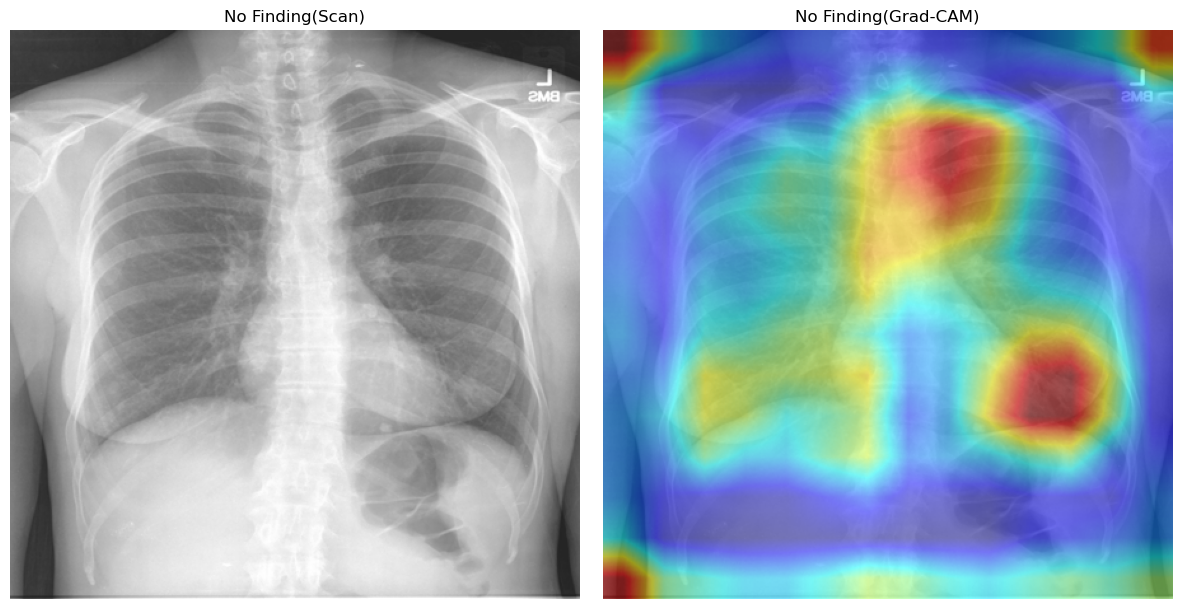

In [69]:
selected_index=7
print(val_df.loc[selected_index].target)
sample_image_path ="images/images_normalized/"+val_df.loc[selected_index].filename  # Replace with your image path
plot_gradcam(sample_image_path)

##### ZERO-SHOT VISUALIZATION WITH SHAP

In [42]:
# Define the class names (your 14 disease labels)
class_names = [
    'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
    'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
    'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
    'Support Devices', 'No Finding'
]

text_model = text_model.to("cpu")
text_model.eval()
class ProjectionLayer(torch.nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.projection = torch.nn.Linear(input_dim, num_classes)

    def forward(self, embeddings):
        return self.projection(embeddings)

# Instantiate the projection layer
projection_layer = ProjectionLayer(input_dim=128, num_classes=len(class_names)).to("cpu")

def predict_proba_shap(texts):
    """
    Prediction function for SHAP that takes a list of text inputs and outputs probabilities for each class.
    Handles inputs with masked tokens ([MASK]) generated by SHAP.
    """

    # Ensure the input is a list of strings
#     if isinstance(texts, str):
#         texts = [texts]
#     elif not isinstance(texts, list) or not all(isinstance(t, str) for t in texts):
#         raise ValueError("Input to predict_proba_shap must be a string or a list of strings.")
    if isinstance(texts, str):
        texts = [texts]
    elif isinstance(texts, np.ndarray):  # SHAP might convert input to a NumPy array
        texts = texts.tolist()  # Convert NumPy array to list
    elif isinstance(texts, list) and all(isinstance(t, list) for t in texts):
        # If SHAP generates lists of tokens, join them into strings
        texts = [' '.join(t) if isinstance(t, list) else t for t in texts]

    with torch.no_grad():
        # Tokenize the input texts
        tokenized = tokenizer.batch_encode_plus(
            batch_text_or_text_pairs=texts,
            add_special_tokens=True,
            padding='longest',
            return_tensors='pt'
        ).to('cpu')  # Use CPU for inference

        # Get embeddings from the text model
        outputs = text_model.get_projected_text_embeddings(
            input_ids=tokenized.input_ids,
            attention_mask=tokenized.attention_mask
        )
        logits = projection_layer(outputs)

        # Convert logits to probabilities
        probabilities = torch.softmax(logits, dim=1).cpu().numpy()
    return probabilities
        # Convert outputs to probabilities using softmax
#         probabilities = torch.softmax(outputs, dim=1).cpu().numpy()
#     return probabilities


# Instantiate SHAP Explainer
explainer = shap.Explainer(predict_proba_shap, tokenizer,output_names=class_names)
# Example sample report (replace with a real report)

In [68]:
sample_report = val_df.loc[selected_index].reports
# Explain the model's prediction
shap_values = explainer([sample_report])
shap.plots.text(shap_values)


### FINETUNING BIOVIL-T

In [12]:
!nvidia-smi

Fri Nov 22 20:30:43 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.107.02             Driver Version: 550.107.02     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100 80GB PCIe          Off |   00000000:E3:00.0 Off |                    0 |
| N/A   28C    P0             66W /  300W |    1207MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [5]:
torch.cuda.empty_cache()

In [20]:
import torch
import numpy as np

# Dynamically calculate class weights
def calculate_class_weights(dataframe, disease_columns):
    class_counts = dataframe[disease_columns].sum(axis=0).values  # Sum occurrences for each class
    total_samples = len(dataframe)  # Total number of samples
    class_weights = total_samples / (len(disease_columns) * class_counts)  # Inverse frequency scaling
    class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)  # Convert to tensor
    return class_weights

# Apply weights to BCEWithLogitsLoss
class_weights = calculate_class_weights(train_df_augmented, disease_columns)
class_weights

tensor([1.1410, 0.5224, 0.3578, 1.5037, 1.6676, 2.8276, 1.1825, 1.0448, 4.3357,
        1.3205, 1.4452, 2.0979, 1.3341, 0.2239], device='cuda:0')

##### DATA LOADER

In [7]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize to match model input
    transforms.CenterCrop(448),
    transforms.ToTensor(),
])


class IUXRayDatasetForAlignment(Dataset):
    def __init__(self, dataframe, image_dir, tokenizer, max_length=512, transform=None, text_augmenter=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
#         self.disease_columns = disease_columns
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.transform = transform
        self.text_augmenter = text_augmenter

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]

        # Load and preprocess the image
        image_path = os.path.join(self.image_dir, row['filename'])
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
            image = image.to(torch.float32)

        # Process the text
        report = row["reports"]
        if self.text_augmenter:
            report = self.text_augmenter.augment(report)

        # Tokenize the text
        tokenized_report = self.tokenizer(
            report,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        # Extract multi-labels
#         labels = torch.tensor(row[self.disease_columns].astype(float).values, dtype=torch.float32)

        return {
            "current_image": image,
            "input_ids": tokenized_report["input_ids"].squeeze(0),
            "attention_mask": tokenized_report["attention_mask"].squeeze(0),
            
        }

# Create Dataset Instances
train_dataset = IUXRayDatasetForAlignment(
    dataframe=train_df_cleaned,
    image_dir=image_dir,
    tokenizer=tokenizer,
    transform=transform
)

val_dataset = IUXRayDatasetForAlignment(
    dataframe=val_df_cleaned,
    image_dir=image_dir,
    tokenizer=tokenizer,
    transform=transform
)
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


CLEANING TRAIN
Invalid row at index 429: Empty report
Invalid row at index 594: Empty report
Invalid row at index 722: Empty report
Invalid row at index 726: Empty report
Invalid row at index 943: Empty report
Invalid row at index 970: Empty report
Invalid row at index 1012: Empty report
Invalid row at index 1082: Empty report
Invalid row at index 1146: Empty report
Invalid row at index 1162: Empty report
Invalid row at index 1460: Empty report
Invalid row at index 1899: Empty report
Invalid row at index 1981: Empty report
Invalid row at index 2044: Empty report
Invalid row at index 2145: Empty report
Invalid row at index 2532: Empty report
Invalid row at index 2577: Empty report
Invalid row at index 2821: Empty report
Invalid row at index 2967: Empty report
CLEARNING VAL
Invalid row at index 216: Empty report
Invalid row at index 217: Empty report


##### FINETUNING ON CONTRASTIVE LOSS (WITH NEG SAMPLES)

In [9]:
# Define Contrastive Loss
class ContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.1):
        super(ContrastiveLoss, self).__init__()
        self.temperature = temperature

    def forward(self, image_embeddings, text_embeddings):
        # Normalize embeddings
        image_embeddings = F.normalize(image_embeddings, p=2, dim=1)
        text_embeddings = F.normalize(text_embeddings, p=2, dim=1)

        # Compute similarity matrix
        similarity_matrix = torch.mm(image_embeddings, text_embeddings.T) / self.temperature

        # Labels are diagonal (positive pairs)
        labels = torch.arange(similarity_matrix.size(0)).to(similarity_matrix.device)

        # Cross-entropy loss considers both positive and negative pairs
        loss = F.cross_entropy(similarity_matrix, labels)
        return loss
    

# Initialize model, optimizer, and scheduler
image_model = image_model.to(device)
text_model = text_model.to(device)
criterion = ContrastiveLoss(temperature=0.1)
optimizer = AdamW(
    list(image_model.parameters()) + list(text_model.parameters()),
    lr=1e-4,
    weight_decay=1e-5
)
scheduler = CosineAnnealingLR(optimizer, T_max=5)
scaler = GradScaler()
# Early Stopping Parameters
early_stop_patience = 5
best_val_loss = float('inf')
early_stop_counter = 0

# TensorBoard writer for logging
writer = SummaryWriter(log_dir="runs/biovil_finetuning")

# Training Loop
def train_one_epoch(image_model, text_model, loader, criterion, optimizer):
    image_model.train()
    text_model.train()
    total_loss = 0.0

    for batch in loader:
        current_image = batch["current_image"].to(device)
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        optimizer.zero_grad()

        with autocast():
            current_embeddings = image_model.forward(current_image).projected_global_embedding
            current_embeddings = F.normalize(current_embeddings, dim=-1)
            text_embeddings = text_model.get_projected_text_embeddings(
                input_ids=input_ids, attention_mask=attention_mask
            )
            loss = criterion(current_embeddings, text_embeddings)

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(
            list(image_model.parameters()) + list(text_model.parameters()),
            max_norm=1.0
        )
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

    return total_loss / len(loader)

# Validation Loop
def validate(image_model, text_model, loader, criterion):
    image_model.eval()
    text_model.eval()
    total_loss = 0.0
    total_cosine_similarity = 0.0
    num_samples = 0

    with torch.no_grad():
        for batch in loader:
            current_image = batch["current_image"].to(device)
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            current_embeddings = image_model.forward(current_image).projected_global_embedding
            current_embeddings = F.normalize(current_embeddings, dim=-1)
            text_embeddings = text_model.get_projected_text_embeddings(
                input_ids=input_ids, attention_mask=attention_mask
            )
            loss = criterion(current_embeddings, text_embeddings)
            total_loss += loss.item()
            
            # Calculate cosine similarity for positive pairs
            cosine_sim = F.cosine_similarity(current_embeddings, text_embeddings, dim=1).mean().item()
            total_cosine_similarity += cosine_sim * current_embeddings.size(0)
            num_samples += current_embeddings.size(0)

    avg_loss = total_loss / len(loader)
    avg_cosine_similarity = total_cosine_similarity / num_samples
    return avg_loss, avg_cosine_similarity

# Training with Early Stopping
num_epochs = 20
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    train_loss = train_one_epoch(image_model, text_model, train_loader, criterion, optimizer)
    val_loss,avg_similarity = validate(image_model, text_model, val_loader, criterion)

    scheduler.step()
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    writer.add_scalar("Loss/Train", train_loss, epoch)
    writer.add_scalar("Loss/Validation", val_loss, epoch)
    writer.add_scalar("Similarity/Validation", avg_similarity, epoch)

    print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Avg Similarity: {avg_similarity:.4f}")
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(image_model.state_dict(), "contrastive_image_model.pth")
        torch.save(text_model.state_dict(), "contrastive_text_model.pth")
        print("Validation loss improved. Models saved.")
    else:
        early_stop_counter += 1
        print(f"No improvement in validation loss for {early_stop_counter} epoch(s).")

    if early_stop_counter >= early_stop_patience:
        print("Early stopping triggered.")
        break

writer.close()


Epoch 1/20
Train Loss: 1.8490, Val Loss: 1.9687, Avg Similarity: 0.5206
Validation loss improved. Models saved.

Epoch 2/20
Train Loss: 1.5089, Val Loss: 2.0461, Avg Similarity: 0.4877
No improvement in validation loss for 1 epoch(s).

Epoch 3/20
Train Loss: 1.3486, Val Loss: 1.9582, Avg Similarity: 0.5273
Validation loss improved. Models saved.

Epoch 4/20
Train Loss: 1.1063, Val Loss: 1.8983, Avg Similarity: 0.5515
Validation loss improved. Models saved.

Epoch 5/20
Train Loss: 0.9338, Val Loss: 1.9679, Avg Similarity: 0.5318
No improvement in validation loss for 1 epoch(s).

Epoch 6/20
Train Loss: 0.8623, Val Loss: 1.9741, Avg Similarity: 0.5332
No improvement in validation loss for 2 epoch(s).

Epoch 7/20
Train Loss: 0.8564, Val Loss: 2.0278, Avg Similarity: 0.5165
No improvement in validation loss for 3 epoch(s).

Epoch 8/20
Train Loss: 0.8867, Val Loss: 2.0671, Avg Similarity: 0.5124
No improvement in validation loss for 4 epoch(s).

Epoch 9/20
Train Loss: 0.9194, Val Loss: 2.12

##### DOWNLOADED THE LOSS DATA FROM TENSORBOARD LOL

In [15]:
train_loss=pd.read_csv('runs/train_loss.csv')
val_loss=pd.read_csv('runs/val_loss.csv')
sim_curve = pd.read_csv('runs/sim_curve.csv')

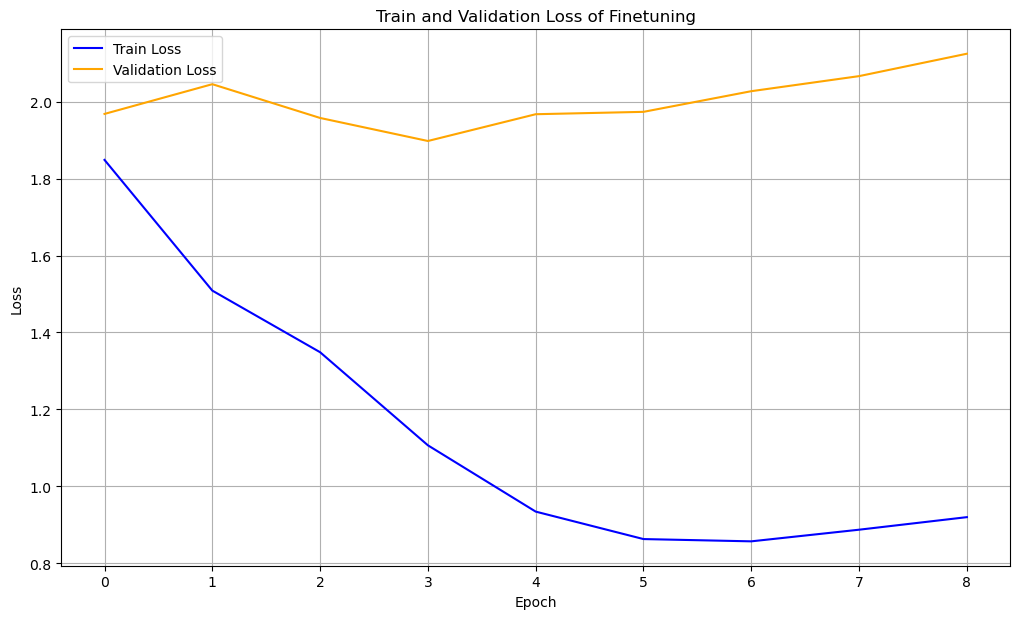

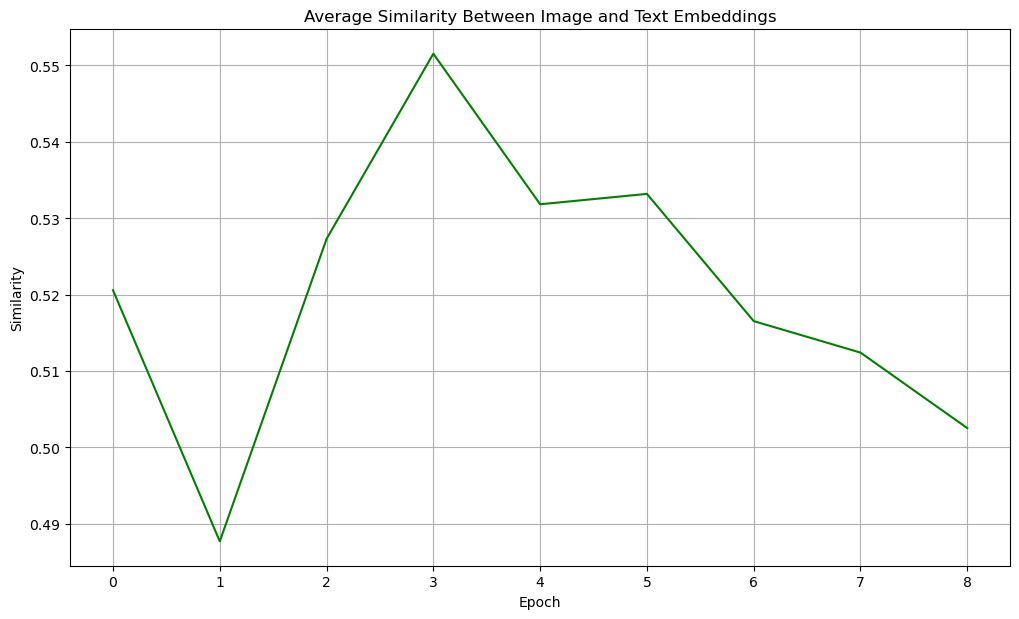

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Plot Train Loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss['Step'], train_loss['Value'], label='Train Loss', color='blue')
plt.plot(val_loss['Step'], val_loss['Value'], label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss of Finetuning')
plt.legend()
plt.grid(True)
plt.tight_layout(pad=0)
plt.savefig('train_loss_curve.png')

# Plot Similarity Curve separately
plt.figure(figsize=(10, 6))
plt.plot(sim_curve['Step'], sim_curve['Value'], label='Average Similarity', color='green')
plt.xlabel('Epoch')
plt.ylabel('Similarity')
plt.title('Average Similarity Between Image and Text Embeddings')
plt.grid(True)

plt.tight_layout(pad=0)

plt.savefig('text_image_emb_sim.png')

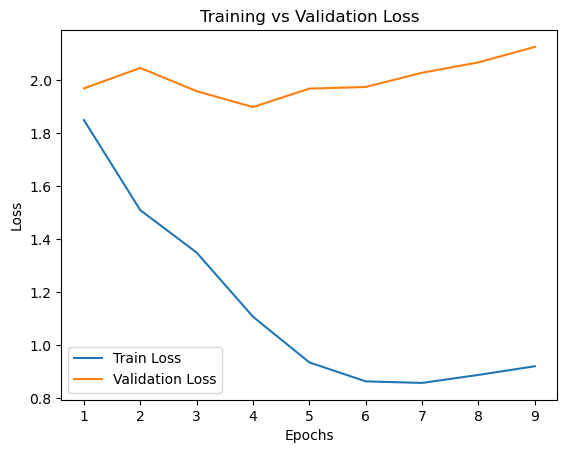

In [12]:
import matplotlib.pyplot as plt

# Use the length of train_losses (or val_losses, as they should have the same length)
epochs = range(1, len(train_losses) + 1)

# Plot training and validation loss
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()


##### LOAD THE FINETUNED MODEL

In [26]:
# Load the saved weights
image_checkpoint_path = "contrastive_image_model.pth"
state_dict = torch.load(image_checkpoint_path, map_location=device)  # Adjust map_location if needed
image_model.load_state_dict(state_dict)
image_model.eval()

text_checkpoint_path = "contrastive_text_model.pth"
state_dict = torch.load(text_checkpoint_path, map_location=device)  # Adjust map_location if needed
text_model.load_state_dict(state_dict)
text_model.eval()


CXRBertModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.25, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.25, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

##### RE-DO EMBEDDING QUALITY CHECK

In [29]:
image_embeddings,text_embeddings=checkEmbQual(val_df_cleaned)
# Correctly pass the dictionary for embeddings
image_embeddings_data, image_labels = prepare_data_for_visualization(image_embeddings)  # image_embeddings should be a dictionary
text_embeddings_data, text_labels = prepare_data_for_visualization(text_embeddings)    # text_embeddings should also be a dictionary
# Reduce dimensionality (e.g., PCA to 50 components)
reduced_image_embeddings = reduce_dimensionality(image_embeddings_data, method="pca", n_components=16)
reduced_text_embeddings = reduce_dimensionality(text_embeddings_data, method="pca", n_components=16)
visualize_with_tsne(reduced_image_embeddings, image_labels, "t-SNE for Image Embeddings", disease_columns)
print(evaluate_pairwise_distances(image_embeddings_data, image_labels))
print(evaluate_pairwise_distances(text_embeddings_data, image_labels))

Processing:  Enlarged Cardiomediastinum


6it [00:00,  9.70it/s]


Processing:  Cardiomegaly


37it [00:03, 10.54it/s]


Processing:  Lung Opacity


46it [00:04, 10.83it/s]


Processing:  Lung Lesion


15it [00:01, 10.79it/s]


Processing:  Edema


5it [00:00, 10.67it/s]


Processing:  Consolidation


4it [00:00, 10.93it/s]


Processing:  Pneumonia


6it [00:00, 11.25it/s]


Processing:  Atelectasis


20it [00:01, 10.65it/s]


Processing:  Pneumothorax


2it [00:00, 10.09it/s]


Processing:  Pleural Effusion


15it [00:01, 10.93it/s]


Processing:  Pleural Other


5it [00:00, 11.39it/s]


Processing:  Fracture


11it [00:01, 10.81it/s]


Processing:  Support Devices


15it [00:01, 11.04it/s]


Processing:  No Finding


129it [00:11, 10.79it/s]


##### TOP-3 CLASSIFICATION ACC WITH FINETUNED BIOVIL-T

In [72]:
val_df_cleaned['predicted_top_k'] = populate_predicted_top_k(
    val_df_cleaned, image_dir, disease_columns, image_model, text_model, tokenizer, k
)
top_k_accuracy_results = compute_top_k_accuracy_from_columns(val_df_cleaned, disease_columns, k=3)
top_k_accuracy_results

100%|██████████| 332/332 [00:31<00:00, 10.55it/s]


{'No Finding': {'top-1': 0.7906976744186046,
  'top-2': 0.8604651162790697,
  'top-3': 0.9069767441860465,
  'total': 129},
 'Cardiomegaly': {'top-1': 0.35135135135135137,
  'top-2': 0.4864864864864865,
  'top-3': 0.5675675675675675,
  'total': 37},
 'Pleural Other': {'top-1': 0.0, 'top-2': 0.0, 'top-3': 0.2, 'total': 5},
 'Lung Lesion': {'top-1': 0.5333333333333333,
  'top-2': 0.7333333333333333,
  'top-3': 0.8,
  'total': 15},
 'Atelectasis': {'top-1': 0.35, 'top-2': 0.65, 'top-3': 0.7, 'total': 20},
 'Pleural Effusion': {'top-1': 0.4666666666666667,
  'top-2': 0.8,
  'top-3': 0.8666666666666667,
  'total': 15},
 'Lung Opacity': {'top-1': 0.34782608695652173,
  'top-2': 0.45652173913043476,
  'top-3': 0.5869565217391305,
  'total': 46},
 'Support Devices': {'top-1': 0.6,
  'top-2': 0.6666666666666666,
  'top-3': 0.8,
  'total': 15},
 'Pneumonia': {'top-1': 1.0, 'top-2': 1.0, 'top-3': 1.0, 'total': 6},
 'Fracture': {'top-1': 0.45454545454545453,
  'top-2': 0.7272727272727273,
  'top-3

### EXTRAS OF THE PAPER

/tmp/ipykernel_117807/709876685.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("tab20")


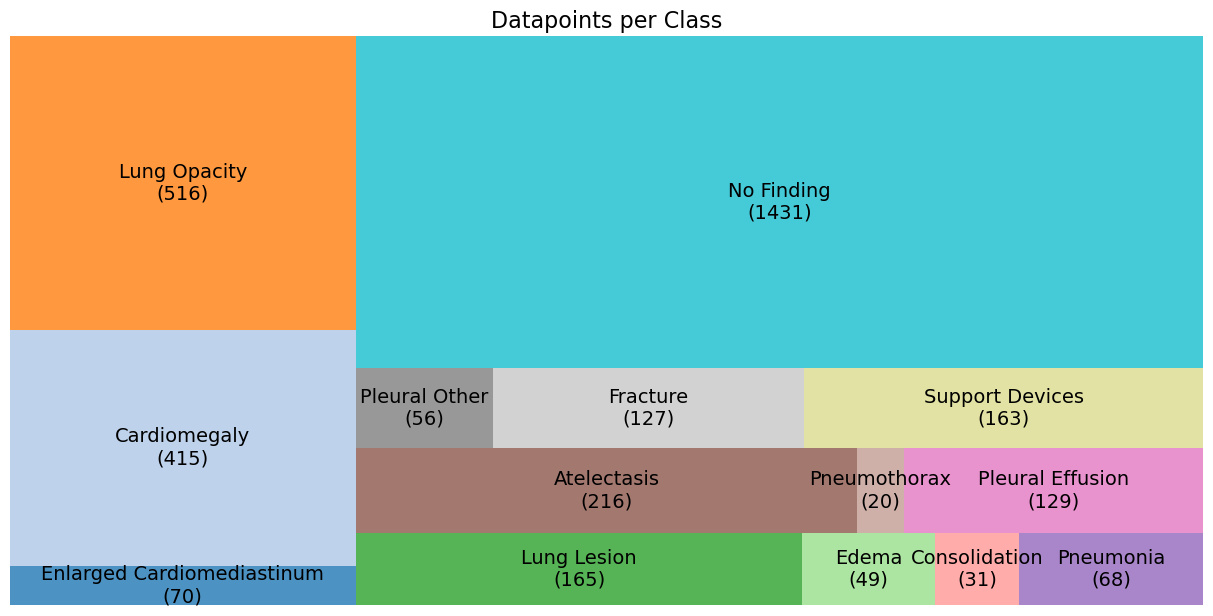

In [33]:
# Re-import libraries and re-define the data
import matplotlib.pyplot as plt
import squarify
import matplotlib.cm as cm

# Data
classes = [
    "Enlarged Cardiomediastinum", "Cardiomegaly", "Lung Opacity", 
    "Lung Lesion", "Edema", "Consolidation", "Pneumonia", 
    "Atelectasis", "Pneumothorax", "Pleural Effusion", 
    "Pleural Other", "Fracture", "Support Devices", "No Finding"
]
datapoints = [
    70, 415, 516, 165, 49, 31, 68, 216, 20, 129, 
    56, 127, 163, 1431
]

# Combine class names and datapoints for labels
labels = [f"{cls}\n({dp})" for cls, dp in zip(classes, datapoints)]

# Select the "tab20" colormap
cmap = cm.get_cmap("tab20")
colors = [cmap(i / len(datapoints)) for i in range(len(datapoints))]

# Create the treemap
plt.figure(figsize=(12, 6))
squarify.plot(sizes=datapoints, label=labels, color=colors, alpha=0.8, text_kwargs={'fontsize':14})
plt.title("Datapoints per Class", fontsize=16)
plt.axis('off')  # No axes for a clean look
plt.tight_layout(pad=0)
plt.savefig('treemap_dp.png')


In [42]:
# Check the distribution of samples for each label
print(train_df-cleaned[disease_columns].sum(axis=0))

Enlarged Cardiomediastinum      57
Cardiomegaly                   336
Lung Opacity                   418
Lung Lesion                    134
Edema                           39
Consolidation                   23
Pneumonia                       55
Atelectasis                    174
Pneumothorax                    15
Pleural Effusion               101
Pleural Other                   45
Fracture                       103
Support Devices                132
No Finding                    1159
dtype: int64


In [281]:
from health_multimodal.vlp import ImageTextInferenceEngine

resized_sim_map = ImageTextInferenceEngine.convert_similarity_to_image_size(
    smoothed_similarity_map,
    width=local_img_emb.shape[1],
    height=local_img_emb.shape[0],
    resize_size=512,
    crop_size=448,
    val_img_transform=transform,
    interpolation='bilinear',
)

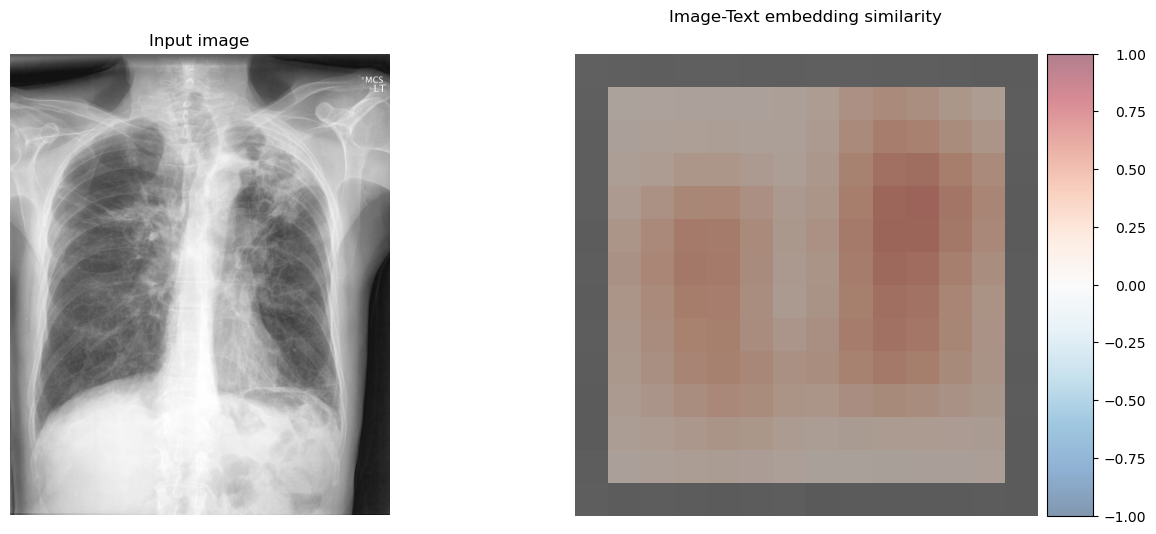

In [283]:
from health_multimodal.common.visualization import plot_phrase_grounding_similarity_map,_plot_isolines,_plot_heatmap,_plot_bounding_boxes
TypeBox = Tuple[float, float, float, float]
bboxes = [
    (10, 168, 124, 101),
]
def plot_phrase_grounding_similarity_map(
    image_path: Path, similarity_map: np.ndarray, bboxes) -> plt.Figure:
    """Plot visualization of the input image, the similarity heatmap and the heatmap isolines.

    :param image_path: Path to the input image.
    :param similarity_map: Phase grounding similarity map of the same size as the image.
    :param bboxes: Optional list of bounding boxes to plot on the image.
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    image = Image.open(image_path).convert("RGB")
    title="Input image"
    axis=axes[0]
    axis.imshow(image)
    axis.axis("off")
    if title is not None:
        axis.set_title(title)
        
#     _plot_isolines(image, similarity_map, axis=axes[1], title="Similarity isolines")
    _plot_heatmap(image, similarity_map, figure=fig, axis=axes[1], title="Image-Text embedding similarity")
    if bboxes is not None:
        _plot_bounding_boxes(ax=axes[1], bboxes=bboxes)
    return fig

def plot_phrase_grounding(bboxes: List[TypeBox]) -> None:
    similarity_map = resized_sim_map
    plot_phrase_grounding_similarity_map(
        image_path=example_image_path,
        similarity_map=similarity_map,
        bboxes=bboxes
    )
plot_phrase_grounding(bboxes)